In [1]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np 

In [10]:
type(np.uint32(1))

numpy.uint32

In [30]:
a = np.array([1])
a = np.float32(1)
a = np.array(1.11111111111, np.float32)
a = a.astype(np.float32)

In [31]:
a_gpu = cuda.mem_alloc(a.nbytes)

In [32]:
cuda.memcpy_htod(a_gpu, a)

In [20]:
a = np.float32(1)
type(a)

numpy.float32

In [21]:
a = np.array([1]).astype(np.float32)
type(a)

numpy.ndarray

In [23]:
a.shape

(1,)

In [26]:
foo = np.array(1.11111111111, np.float64)

In [27]:
foo.shape

()

In [28]:
type(foo)

numpy.ndarray

In [29]:
foo

array(1.11111111111)

## Mako templates

In [5]:
from mako.lookup import TemplateLookup
import pwd,os,sys

In [6]:
ctx = {}
ctx['const_parameters'] = ['a','C']

In [7]:
%%writefile mytemplate.mako

%for param in const_parameters:
    __constant__ float ${param} = 0.0f;
%endfor

Overwriting mytemplate.mako


In [8]:
lookup = TemplateLookup(directories=sys.path,module_directory='/tmp/test-module')

In [9]:
sde_template = lookup.get_template('mytemplate.mako')
kernel_source = sde_template.render(**ctx)


In [10]:
with open("/tmp/source.c", 'w') as file:
    print >> file, kernel_source

In [11]:
!indent  -linux -sob -l120 /tmp/source.c

In [ ]:
# %load /tmp/source.c

__constant__ float a = 0.0f;
__constant__ float C = 0.0f;


In [11]:
!indent  -linux -sob -l120 1.cu

In [ ]:
# %load 1.cu
#ifndef __CU_RNG_H
#define __CU_RNG_H

#include <float.h>

#define PI 3.14159265358979f

/*
 * Return a uniformly distributed random number from the
 * [0;1] range.
 */

__device__ float rng_kiss32(unsigned int *x, unsigned int *y, unsigned int *z, unsigned int *w)
{
	*x = 69069 * *x + 1234567;	// CONG
	*z = 36969 * (*z & 65535) + (*z >> 16);	// znew
	*w = 18000 * (*w & 65535) + (*w >> 16);	// wnew  & 6553?
	*y ^= (*y << 17);	// SHR3
	*y ^= (*y >> 13);
	*y ^= (*y << 5);

	return ((((*z << 16) + *w) ^ *x) + *y) * 2.328306e-10f;	// (MWC ^ CONG) + SHR3
}

/*
 * Generate two normal variates given two uniform variates.
 */
__device__ void bm_trans(float &u1, float &u2)
{
	float r = sqrtf(-2.0f * logf(u1 + FLT_EPSILON));
	float phi = 2.0f * PI * u2;
	u1 = r * cosf(phi);
	u2 = r * sinf(phi);
}

#endif				/* __CU_RNG_H */

// Constants
__constant__ float gamma_ = 0.0f;
__constant__ float ns = 0.0f;
__constant__ float force = 0.0f;
__constant__ float d0 = 0.0f;
__constant__ float psd = 0.0f;

__constant__ float dt = 0.0f;
__constant__ unsigned int samples = 0;

// System of differential equations to solve.
__device__ inline void RHS(float &dx0, float x0, float &dx1, float x1, float t)
{
	dx0 = x1;
	dx1 = -psd * sinf(x0) - gamma_ * x1 + force;
}

__global__ void AdvanceSim(unsigned int *rng_state, float *cx0, float *cx1, float ct)
{
	int idx = blockIdx.x * blockDim.x + threadIdx.x;
	int i;
	float x0, xt0, x1, xt1, n0, n1, t;

	unsigned int lrng_state[4];

	x0 = cx0[idx];
	x1 = cx1[idx];

	t = ct;

	lrng_state[0] = rng_state[4 * idx + 0];
	lrng_state[1] = rng_state[4 * idx + 1];
	lrng_state[2] = rng_state[4 * idx + 2];
	lrng_state[3] = rng_state[4 * idx + 3];

	// Additional local variables that depend on changing parameters.

	float xtt0, xim0;
	float xtt1, xim1;

	for (i = 1; i <= samples; i++) {
		if (!(i & 1)) {
			n0 = n1;
		} else {
			n0 = rng_kiss32(lrng_state + 0, lrng_state + 1, lrng_state + 2, lrng_state + 3);
			n1 = rng_kiss32(lrng_state + 0, lrng_state + 1, lrng_state + 2, lrng_state + 3);
			bm_trans(n0, n1);
		}

		RHS(xt0, x0, xt1, x1, t);

		xim0 = x0 + xt0 * dt;
		xim1 = x1 + xt1 * dt + ns * n0;
		;
		t = ct + i * dt;

		RHS(xtt0, xim0, xtt1, xim1, t);

		x0 += 0.5f * dt * (xt0 + xtt0);
		x1 += 0.5f * dt * (xt1 + xtt1)
		    + ns * n0;
	}

	cx0[idx] = x0;
	cx1[idx] = x1;

	rng_state[4 * idx + 0] = lrng_state[0];
	rng_state[4 * idx + 1] = lrng_state[1];
	rng_state[4 * idx + 2] = lrng_state[2];
	rng_state[4 * idx + 3] = lrng_state[3];
}


In [26]:
import sys
sys.path.append(os.getcwd())

### Code Generation

In [12]:
import sde
import sympy

In [13]:
sde.KernelCodePrinter()

`local_vars` przy inicjalizacji jest słownikiem z lambami:

In [3]:
local_vars = { 'ns': lambda sdei: sympy.sqrt(sdei.S.d0 * sdei.S.dt) }

class tst(object):
    pass

TST=tst()
TST.S = sde.S()
TST.S.d0 = sympy.Symbol('d0')


taki `local_vars` jest atrybutem w instancji SDE:

In [5]:
local_vars['ns'](TST)

sqrt(d0*dt)

In [6]:
sde.KernelCodePrinter().doprint(local_vars['ns'](TST))

'powf((d0*dt),(1.0L/2.0L))'

In [58]:
from sympy.core import basic

In [60]:
basic.S?

In [61]:
basic.S.NegativeOne

-1

In [62]:
import sde
import sympy
import numpy

In [113]:
params = {'force': 'DC bias current',
          'gamma_': 'damping constant',
          'psd': 'potential strenght',
          'd0': 'noise strength'}

local_vars = { 'ns': lambda sdei: sympy.sqrt(sdei.S.d0 * sdei.S.dt * 2.0 * sdei.S.gamma_) }

code = """
    dx0 = x1;
    dx1 = -psd * sinf(x0) - gamma_ * x1 + force;
"""

noise_map = {1: ['ns']}

defaults = {'force':0.5,
            'gamma_':0.5,
            'psd':1.0,
            'd0':0.025,
            'spp':1000,
            'paths':8192,
            'simperiods':10000,
            'samples':1000,
            'output':'BLEBL',
            'precision':'double',
           }


period_map = {0: sde.PeriodInfo(period=2.0 * numpy.pi, freq=1)}

In [114]:
sde_ = sde.SDE(code, params, num_vars=2, num_noises=1, noise_map=noise_map, \
               period_map=period_map,local_vars=local_vars,defaults=defaults,\
               args=["--force","0.666"]
              )

In [115]:
sde_.options.force

0.66600000000000004

In [116]:
sde_.options.precision

'double'

In [117]:
sde_.parser.par_single

{'d0', 'force', 'gamma_', 'psd'}

In [123]:
sde_.local_vars

{'ns': 1.4142135623731*sqrt(d0*dt*gamma_)}

In [122]:
local_vars['ns']

<function __main__.<lambda>>

In [107]:
print sde.SRK2.get_source(sde_,sde_.parser.par_single,[],sde_.local_vars )

#ifndef __CU_RNG_H
#define __CU_RNG_H

#include <float.h>

#define PI 3.14159265358979f

/*
 * Return a uniformly distributed random number from the
 * [0;1] range.
 */


__device__ float rng_kiss32(unsigned int *x, unsigned int *y,
		unsigned int *z, unsigned int *w)
{
	*x = 69069 * *x + 1234567;		// CONG
	*z = 36969 * (*z & 65535) + (*z >> 16);	// znew
	*w = 18000 * (*w & 65535) + (*w >> 16);	// wnew  & 6553?
	*y ^= (*y << 17);			// SHR3
	*y ^= (*y >> 13);
	*y ^= (*y << 5);

	return ((((*z << 16) + *w) ^ *x) + *y) * 2.328306e-10f;	// (MWC ^ CONG) + SHR3
}


/*
 * Generate two normal variates given two uniform variates.
 */
__device__ void bm_trans(float& u1, float& u2)
{
	float r = sqrtf(-2.0f * logf(u1 + FLT_EPSILON));
	float phi = 2.0f * PI * u2;
	u1 = r * cosf(phi);
	u2 = r * sinf(phi);
}

#endif /* __CU_RNG_H */



// Constants
	__constant__ float gamma_ = 0.0f;
	__constant__ float force = 0.0f;
	__constant__ float psd = 0.0f;
	__constant__ float d0 = 0.0f;

__constant__ float dt

In [108]:
with open("/tmp/source.c", 'w') as file:
    print >> file, sde._convert_to_double(sde.SRK2.get_source(sde_,sde_.parser.par_single,[],sde_.local_vars ))

In [109]:
!indent  -linux -sob -l120 /tmp/source.c

In [1]:
import sympy
import sys

sympy.init_printing(pretty_print=True)

In [2]:
a = sympy.Symbol('a')

In [5]:
from sympy.parsing.sympy_parser import parse_expr
expr = parse_expr("a+2*c+a")


In [6]:
expr.free_symbols

In [10]:
for symb in expr.free_symbols:
    print(symb,id(symb))

(c, 139872886946304)
(a, 139872886945584)


In [9]:
id(a)

In [11]:
c

NameError: name 'c' is not defined

In [12]:
c = sympy.Symbol('c')

In [13]:
id(c)

In [17]:
import copy
c2 = copy.copy(c)

In [18]:
id(c2)

In [19]:
sympy.Symbol??


In [47]:
c_in_a_list = list(expr.free_symbols)[0]

In [48]:
c_in_a_list

In [49]:
c_in_a_list.name

'c'

In [50]:
expr.subs({c_in_a_list:555})

In [51]:
id(c_in_a_list)

In [52]:
c = sympy.Symbol('c')

In [53]:
id(c)

In [54]:
id( sympy.Symbol('c') ) 

In [78]:
with sympy.evaluate(False):
    aa = (a+a).subs({a:1})
    print aa.subs({1:2})

2 + 2


In [94]:
sympy.evaluate(True)
sympy.simplify(aa)

In [97]:
a+a

In [5]:
expr.subs({c:666})

NameError: name 'c' is not defined

In [6]:
symb.name

NameError: name 'symb' is not defined

In [7]:
for symb in expr.free_symbols:
    setattr(sys.modules[__name__], symb.name, sympy.Symbol(symb.name))


In [8]:
c

In [9]:
expr.subs({c:555})

In [43]:
parse_expr("sin(a)").diff(a)

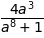

In [53]:
parse_expr("atan(a**4)").diff(a)

### CodePrinter extension

In [38]:
from sde import KernelCodePrinter

In [39]:
KernelCodePrinter().doprint((a/(a**2+1)).diff(a))

'-2*a*a/(a*a + 1)*(a*a + 1) + 1.0/(a*a + 1)'

In [40]:
expr = sympy.sin(a)

In [41]:
expr.func.__name__

'sin'

In [42]:
ble = sympy.Function("ble")

In [43]:
sde.KernelCodePrinter().doprint(ble(a))

'// Not supported in C:\n// ble\nble(a)'

In [44]:
ble(a).func.__name__

'ble'

In [45]:

class MyKernelCodePrinter(KernelCodePrinter):

    def _print_Function(self, expr):
        if expr.func.__name__ == 'ble':
            return 'ble_CUDAf(%s)' % self.stringify(expr.args, ', ')
        else:
            return super(KernelCodePrinter, self)._print_Function(expr)

In [46]:
 MyKernelCodePrinter().doprint(ble(a))

'ble_CUDAf(a)'